## Dataset description

In this study, we present data regarding **ovarian samples**, both healthy and diseased, which are categorized as follows:
* CONTROL - no pathological changes visible,
* ENDOM - endometrial carcinoma,
* HGSC - high-grade serous carcinoma ,
* MUC - mucinous carcinoma 

They were obtained from Fourier Transform Infrared Spectroscopy (FTIR) experiments conducted at AGH University of Science and Technology in Krakow, Poland, and they provide insights into the **molecular composition of tissues**. The data are presented as counts corresponding to peaks in FTIR spectra. Measurements were taken for tissues prepared in two ways:
* Tissues **embedded in paraffin** (PAR).
* Tissues **after deparaffinization** (DEP).

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

### 1. Dataset

Let's bring in the dataset and explore its contents to gain a deeper understanding of the data.

In [26]:
# load the dataset
data_raw = pd.read_excel('../data/data.xlsx')

In [27]:
# describe the dataset including the categorical variables
data_raw.describe(include='all')

,Patient,Sample,Category,Lipids,Unsaturated lipids,CH3 groups,CH2 groups,Ester groups,Unsaturated/saturated lipid ratio,Lipid saturation,...,Band 1450,Band 1390,Band 1240,Band 1080,Band 1310,Band 2850,Band 3060,Biomass_I,Biomass_II,Biomass_Total
count,31912.0,31912,31912,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,...,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000
unique,33.0,50,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2071876.0,N 26,HGSC_par,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3469.0,2964,12812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,24.846343,-0.014731,2.290090,11.151939,-0.161978,-0.011964,4.183101,...,1.029627,0.427061,0.392735,0.629494,0.022107,4.030647,0.099232,39.066903,33.407301,72.474204
std,NaN,NaN,NaN,17.853234,0.008707,1.542136,8.254825,0.072436,0.134562,2.311403,...,0.638488,0.158479,0.168214,0.440272,0.025501,2.986890,0.064941,16.260292,13.094158,27.207239
min,NaN,NaN,NaN,-0.106751,-0.187319,-0.037424,-0.009415,-0.559956,-20.574695,-55.888301,...,-0.071033,-0.132053,-0.101492,-0.589192,-0.202773,-0.010721,-0.378584,-10.508358,-16.230971,-21.257606
25%,NaN,NaN,NaN,2.843458,-0.018647,0.516018,1.189789,-0.211130,-0.020296,2.545845,...,0.325684,0.324803,0.278651,0.428183,0.011896,0.305769,0.058491,29.841367,25.732793,55.898884
50%,NaN,NaN,NaN,30.561344,-0.014549,2.657546,13.817506,-0.164254,-0.005961,4.414173,...,1.164171,0.437147,0.408310,0.571713,0.025279,5.096267,0.096981,39.919484,34.279742,74.904316
75%,NaN,NaN,NaN,40.143874,-0.010121,3.510655,18.601356,-0.115527,-0.004846,5.615389,...,1.515115,0.523619,0.509545,0.734149,0.036505,6.567417,0.138741,50.743708,41.495205,89.928424


From the data shown above, we can notice a few things:
* The dataset contains nearly 32,000 entries across all columns, indicating there might not be any missing data. We'll confirm this shortly.

In [28]:
data_raw.columns[data_raw.isnull().any()]

Index([], dtype='object')

* A total of 50 samples were collected from 33 distinct patients.

* The most common category consists of HGSC samples preserved in paraffin. Let's explore the presence of other categories.

In [29]:
data_raw['Category'].unique()

array(['CONTROL_dep', 'ENDOM_dep', 'HGSC_dep', 'MUC_dep', 'CONTROL_par',
       'ENDOM_par', 'HGSC_par', 'MUC_par'], dtype=object)

As observed, the data originate from samples **preserved in paraffin as well as from samples after deparaffinization**. They **will be handled separately because deparaffinization alters the spectral shape**, making direct comparison impossible. Therefore, they need to be split into two datasets.

In [30]:
# split the data into two datasets: in paraffin and after deparaffinization
data_raw_PAR = data_raw[data_raw.Category.str.contains('par')]
data_raw_DEP = data_raw[data_raw.Category.str.contains('dep')]

# modify the names of categories
data_raw_PAR.loc[:, 'Category'] = data_raw_PAR['Category'].str.replace('_par', '')
data_raw_DEP.loc[:, 'Category'] = data_raw_DEP['Category'].str.replace('_dep', '')

We'll categorize the samples and **examine the population of each category**.

In [31]:
# group paraffine samples into categories
label_counts_PAR = pd.DataFrame(data_raw_PAR.groupby('Category').size(), columns=['Count']).reset_index()

# group deparaffinized samples into categories
label_counts_DEP = pd.DataFrame(data_raw_DEP.groupby('Category').size(), columns=['Count']).reset_index()

Let's create visualizations to illustrate the distribution of each category for both paraffin and deparaffinized samples.

In [32]:
def create_subplot(ax, label_counts, title, total_label):
    
    # Plot for label_counts
    patches, labels = ax.pie(label_counts['Count'], labels=label_counts['Category'], startangle=140)
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    ax.axis('equal')

    # Adjust label distance to prevent overlap
    for label in labels:
        label.set_va('center_baseline')
        label.set_fontweight('bold') 
        if label.get_text() == 'CONTROL':
            label.set_va('bottom')
        if label.get_text()=='HGSC':
            label.set_ha('center')
            label.set_va('top')

    # Add circle to create doughnut chart
    circle = plt.Circle((0, 0), 0.6, color='white')
    ax.add_artist(circle)

    # Calculate and add total count
    total_count = label_counts['Count'].sum()
    ax.text(0, -0.1, f'Total: {total_count}\n {total_label}', ha='center', fontsize=14, weight='bold')

    # Add legend using 'Count' values
    legend_labels = ['{0} - {1}'.format(label, count) for label, count in zip(label_counts['Category'], label_counts['Count'])]
    ax.legend(patches, legend_labels, loc='lower right', fontsize=10, facecolor='whitesmoke')

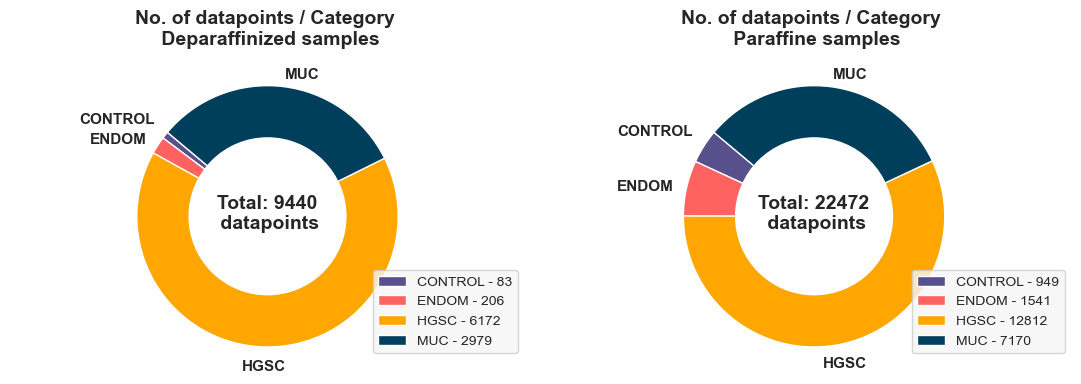

In [33]:
# Create colour palette
palette = ["#58508d","#ff6361","#ffa600", "#003f5c", "#00AAA0", "#bc5090", "#FADA5E", "#4B8BBE"]

# Set the Seaborn theme
sns.set_theme(palette=palette)
    
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot for label_counts_DEP
create_subplot(axs[0], label_counts_DEP, 'No. of datapoints / Category \n Deparaffinized samples', 'datapoints')

# Plot for label_counts_PAR
create_subplot(axs[1], label_counts_PAR, 'No. of datapoints / Category \n Paraffine samples', 'datapoints')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Above, it's evident that the **majority of samples** belong to the high-grade serous carcinoma (**HGSC**) category, followed by mucinous carcinoma (**MUC**) as the second most abundant category. However, in the control group and endometrial carcinoma (ENDOM), the number of data points is significantly lower compared to the other two groups. More importantly, it's **crucial to analyze the origin of data points** in these underrepresented groups by **examining the number of patients associated with each category**. Let's group the entries by category and patient code for further investigation.

In [34]:
label_counts_patient_PAR = (data_raw_PAR.groupby('Category')['Patient']
                           .nunique()
                           .reset_index(name='Count'))
                            
label_counts_patient_DEP = (data_raw_DEP.groupby('Category')['Patient']
                           .nunique()
                           .reset_index(name='Count'))

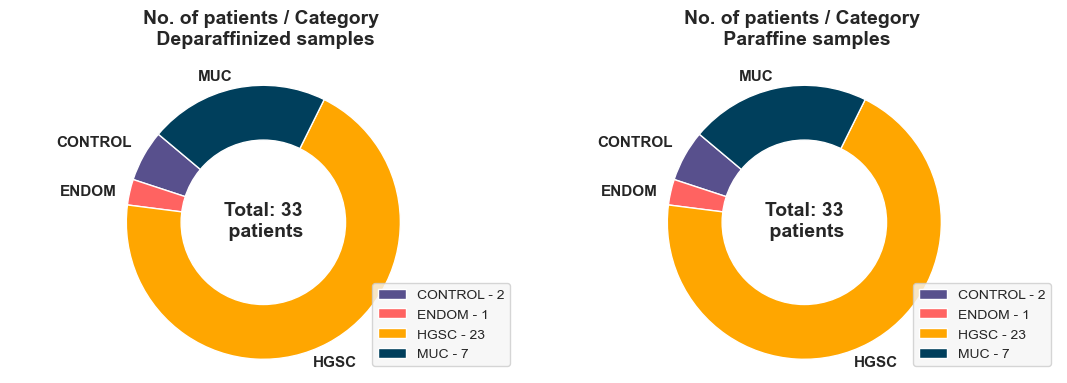

In [35]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot for label_counts_DEP
create_subplot(axs[0], label_counts_patient_DEP, 'No. of patients / Category \n Deparaffinized samples', 'patients')

# Plot for label_counts_PAR
create_subplot(axs[1], label_counts_patient_PAR, 'No. of patients / Category \n Paraffine samples', 'patients')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

From the figures above, it's apparent that there are only two patients in the control group and one patient in the ENDOM group for both types of samples. This insight will be crucial for partitioning the data into training and test sets.

### 2. Dataset splitting

Based on the preceding analysis, it's clear that:

* The number of patients in the CONTROL and ENDOM sample groups is insufficient for a reliable training-test split. Consequently, **classification will exclusively focus on MUC and HGSC samples**.
<br>
* The right method for dividing the data into training and testing sets is through **patient-wise splitting**. This methodology ensures that **data from each patient is allocated exclusively to either the training or test set, thus preventing potential data leakage**. 

    <span style="color:gray">_(Similar problem was described in the following paper: "Training machine learning models on patient level data segregation is crucial in practical clinical applications", Oner et al.medRxiv 2020.04.23.20076406; doi: https://doi.org/10.1101/2020.04.23.20076406)_</span>


    For comparison, we will also generate a dataset where all data points are randomly assigned to either the training or test set, allowing us to **illustrate the impact of data leakage on model performance**.

We'll begin by excluding the data points associated with CONTROL and ENDOM samples.

In [36]:
# remove the datapoints related to CONTROL and ENDOM samples
data_raw_PAR = data_raw_PAR[~data_raw_PAR['Category'].isin(['CONTROL', 'ENDOM'])]
data_raw_DEP = data_raw_DEP[~data_raw_DEP['Category'].isin(['CONTROL', 'ENDOM'])]

#### 2A. Patient-level splitting ####

First, we need to ensure that all patient codes are of the same data type, regardless of whether they contain only numbers or a mix of numbers and letters.

In [37]:
# convert all patient codes to strings to ensure consistent data type
data_raw_PAR.loc[:,'Patient'] = data_raw_PAR['Patient'].astype('str')
data_raw_DEP.loc[:,'Patient'] = data_raw_DEP['Patient'].astype('str')

To effectively divide the data into training and test sets, we'll utilize **Group Shuffle Split**. This method enables random splitting of the data while **ensuring that all data points recorded for a single patient reside exclusively in either the training or test set**.

In [38]:
# initialize GroupShuffleSplit for splitting the data into training and test sets.
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state = 0)

In [39]:
# split samples in paraffine
split = splitter.split(data_raw_PAR, groups=data_raw_PAR['Patient'])
train_inds, test_inds = next(split)

train_PAR_patient = data_raw_PAR.iloc[train_inds]
test_PAR_patient = data_raw_PAR.iloc[test_inds]

In [40]:
# split deparaffinized samples
split = splitter.split(data_raw_DEP, groups=data_raw_DEP['Patient'])
train_inds, test_inds = next(split)

train_DEP_patient = data_raw_DEP.iloc[train_inds]
test_DEP_patient = data_raw_DEP.iloc[test_inds]

Let's confirm that no patient samples are present in both the training and test sets.

In [41]:
# retrieve unique patient IDs from the training set and test set.
A = set(train_PAR_patient['Patient'].unique())
B = set(test_PAR_patient['Patient'].unique())

# find the intersection of unique patient IDs between the training set and test set.
A.intersection(B)

set()

We observe that the intersection of training and test set patient codes does indeed yield an empty set.

In [42]:
# export the datasets
train_PAR_patient.to_csv('../data/train_PAR_patient.csv', index=False)
test_PAR_patient.to_csv('../data/test_PAR_patient.csv', index=False)

train_DEP_patient.to_csv('../data/train_DEP_patient.csv', index=False)
test_DEP_patient.to_csv('../data/test_DEP_patient.csv', index=False)

#### 2B. Standard train-test splitting ####

To contrast with the properly split data mentioned earlier, let's examine a scenario where we directly apply the most standard train-test split to the dataset.

In [46]:
# split the datasets into training and test sets
train_PAR_entry, test_PAR_entry = train_test_split(data_raw_PAR, test_size=0.2, random_state=0)
train_DEP_entry, test_DEP_entry = train_test_split(data_raw_DEP, test_size=0.2, random_state=0)

In [47]:
# export the datasets
train_PAR_entry.to_csv('../data/train_PAR_entry.csv', index=False)
test_PAR_entry.to_csv('../data/test_PAR_entry.csv', index=False)

train_DEP_entry.to_csv('../data/train_DEP_entry.csv', index=False)
test_DEP_entry.to_csv('../data/test_DEP_entry.csv', index=False)

Later on, we'll revisit those datasets to assess the extent of overestimation in the model's performance when we neglect to split the data at the patient level.